In [1]:
import os
os.chdir('../')

In [2]:
import json
from datasets.widerface import WiderTrainTfrecord
import utils as ut
import ipdb

In [3]:
import tensorflow as tf
import numpy as np
from PIL import Image, ImageDraw
from matplotlib import pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
cfg_path = 'base.json'
tfrecord_path = 'datasets/wider_train_cropped128_scaleTo12.18.36_repeat1.tfrecord'
cfg = json.load(open(cfg_path))
tfrecord_obj = WiderTrainTfrecord(tfrecord_path=tfrecord_path)

In [ ]:
### No transformer_fn

In [5]:
dataset = tfrecord_obj.get_dataset(transform_fn=None,
                                   batch_size=1,
                                   n_thread=4,
                                  shuffle_num=10)

Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.


In [6]:
iterator = dataset.make_one_shot_iterator()
sample = iterator.get_next()
sess = tf.Session()

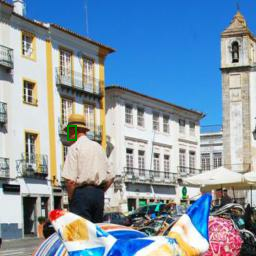

In [47]:
fetched = sess.run(sample)
image = Image.fromarray(fetched['image'].astype(np.uint8)[0], mode='RGB')
boxes = fetched['boxes'][0]

image = ut.np_ops.draw_boxes(image, boxes, width=2)
image

In [48]:
# use transforme_fn

In [5]:
from models.detector import Detector

In [16]:
train_params = {'train_image_shape': 128,
               'anchor_match_thres': 0.3}
detector = Detector(anchor_scales=[12, 18, 32],
                    anchor_strides=[8, 8, 8],
                    train_params=train_params)
def transform_fn(sample):
    image = sample['image']
    boxes = tf.reshape(sample['boxes'], [-1, 4])
    labels = sample['labels']
    anchor_obj = detector.create_anchor_fn()
    cls_t, cls_w, reg_t, reg_w = anchor_obj.encode(boxes)
    sample =  {'image':image, 'boxes':boxes, 'labels':labels,
                'cls_t': cls_t, 'cls_w': cls_w,
                'reg_t': reg_t, 'reg_w': reg_w}
    sample = ut.tf_ops.convert_sample(sample)
    return sample
    
dataset = tfrecord_obj.get_dataset(transform_fn=transform_fn,
                                   batch_size=1,
                                   n_thread=4,
                                   shuffle_num=10)
iterator = dataset.make_one_shot_iterator()
sample = iterator.get_next()
sample = ut.tf_ops.reconvert_sample(sample)


anchor_obj = detector.create_anchor_fn()

batch_codes = sample['reg_t']
batch_scores = tf.to_float(sample['cls_t'])
decode_boxes, decode_scores = detector._decode(anchor_obj, batch_codes, batch_scores)
sample['decode_boxes'] = decode_boxes

sess = tf.Session()

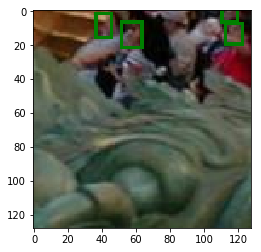

In [17]:
fetched = sess.run(sample)
cls_t = fetched['cls_t']
cls_w = fetched['cls_w']
reg_t = fetched['reg_t']
reg_w = fetched['reg_w']
image = Image.fromarray(fetched['image'].astype(np.uint8)[0], mode='RGB')
boxes = fetched['boxes'][0]
image = ut.np_ops.draw_boxes(image, boxes, width=2)
plt.imshow(image)

In [26]:
decode_boxes = fetched['decode_boxes'][0]
decode_boxes

array([[ -2.4931157, 110.045654 ,   7.237175 , 120.443146 ],
       [  6.488691 ,  51.126495 ,  22.20685  ,  64.12337  ],
       [  1.9977875,  36.3967   ,  16.21898  ,  46.7942   ],
       [  7.9856586, 112.64503  ,  20.709883 , 123.04252  ]],
      dtype=float32)

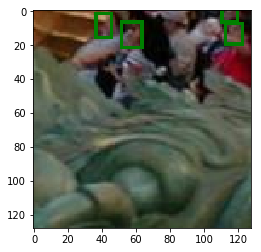

In [27]:
image = Image.fromarray(fetched['image'].astype(np.uint8)[0], mode='RGB')
decode_boxes_image = ut.np_ops.draw_boxes(image, decode_boxes, width=2)
plt.imshow(decode_boxes_image)

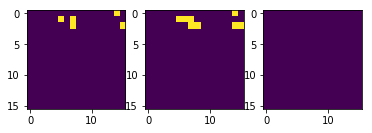

In [28]:
plt_list = cls_t
for i in range(len(plt_list)):
    plt.subplot('1%d%d'%(len(plt_list), i+1))
    plt.imshow(plt_list[i].reshape(16,16))

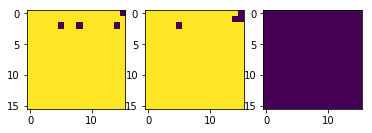

In [29]:
plt_list = cls_w
for i in range(len(plt_list)):
    plt.subplot('1%d%d'%(len(plt_list), i+1))
    plt.imshow(plt_list[i].reshape(16,16))

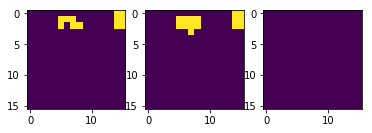

In [30]:
plt_list = reg_w
for i in range(len(plt_list)):
    plt.subplot('1%d%d'%(len(plt_list), i+1))
    plt.imshow(plt_list[i].reshape(16,16))

In [96]:
# use coder

In [101]:
train_params = {'train_image_shape': 128,
               'anchor_match_thres': 0.3}
detector = Detector(anchor_scales=[12, 18, 32],
                    anchor_strides=[8, 8, 8],
                    train_params=train_params)
def transform_fn(sample):
    image = sample['image']
    boxes = tf.reshape(sample['boxes'], [-1, 4])
    labels = sample['labels']
    anchor_obj = detector.create_anchor_fn()
    cls_t, cls_w, reg_t, reg_w = anchor_obj.encode(boxes)
    sample =  {'image':image, 'boxes':boxes, 'labels':labels,
                'cls_t': cls_t, 'cls_w': cls_w,
                'reg_t': reg_t, 'reg_w': reg_w}
    sample = ut.tf_ops.convert_sample(sample)
    return sample
    
dataset = tfrecord_obj.get_dataset(transform_fn=transform_fn,
                                   batch_size=1,
                                   n_thread=4,
                                   shuffle_num=10)
iterator = dataset.make_one_shot_iterator()
sample = iterator.get_next()
sample = ut.tf_ops.reconvert_sample(sample)
sess = tf.Session()